In [31]:
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import sklearn.datasets
from sklearn.metrics import accuracy_score
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# The Iris Dataset

Here are some pictures of the iris subspecies that we will be working with!

### Iris Setosa
![alt text](images/irissetosa2.jpg "setosa")
### Iris Versicolor
![alt text](images/versicolor.jpg "versicolor")
### Iris Virginica
![alt text](images/virginica.jpg "virginica")

## About the Iris Dataset

In [32]:
#  in sklearn datasets, the data is stored in 'data'.  the columns are stored in 'feature_names'
iris = sklearn.datasets.load_iris()
iris_df=pd.DataFrame(iris.data, columns=iris['feature_names'])
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [33]:
#  We will add labels for later to see how well our labeling goes
iris_labeled_df = iris_df.copy(deep=True)
iris_labeled_df['species_index'] = iris['target']
#  'target'  contains the coded species label (0,1,2).  The lookup is in 'target names'.
iris_names = iris['target_names']
# we convert to a dict to add the labels to iris_labeled_df
iris_name_dict = dict(zip(range(4), iris_names ))
iris_labeled_df['species'] = iris_labeled_df['species_index'].map(iris_name_dict)

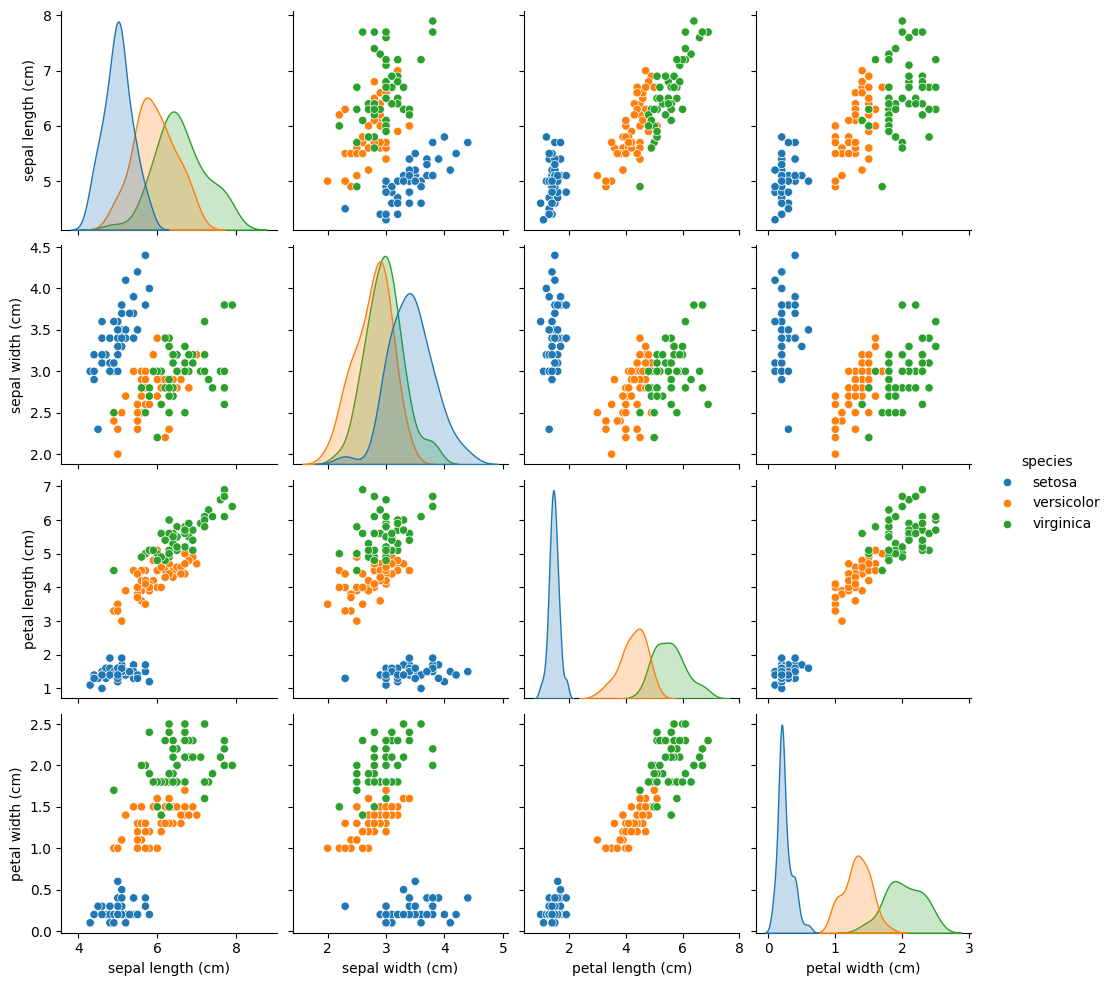

In [34]:
#  We can use pairplot to plot scatterplots of everything with everything else.  We put hisograms on the diagonal
cols = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']
sns.pairplot(iris_labeled_df, vars=cols,  hue='species')

## K-Means

In [35]:
from sklearn.cluster import KMeans

In [36]:
kmeans = KMeans(n_clusters=3, random_state=0)

In [37]:
iris_df['labels'] = kmeans.fit_predict(iris_df)


In [38]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),labels
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,0
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


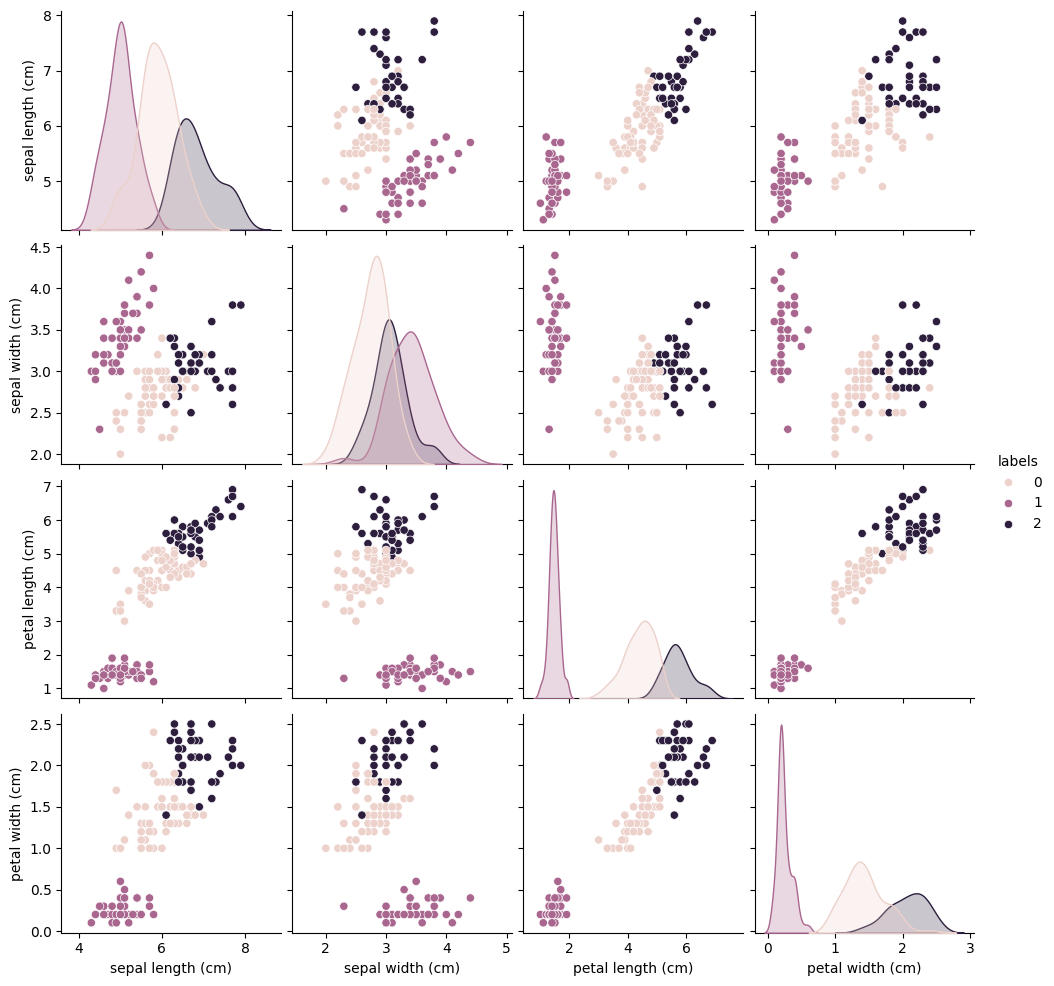

In [39]:
cols = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']
sns.pairplot(iris_df, vars=cols,  hue='labels')

### Accuracy and Confusion

There are a number of accuracy metrics we can use when we have the "correct"  answer to compare to.  In this case, we can compare the species to see how often it gets the correct answer.  The *accuracy* is the ratio of correct assigments to the number of total assignments.  The "confusion matrix" is a $N\times N$ matrix that displays the number of predictions in eatch categorical value by the number of given values.

As a check, the accuracy is the trace (sum of the diagonal values) divided by the total number of cases


In [40]:
from sklearn.metrics import confusion_matrix

In [41]:
confusion_matrix(iris_df.labels, iris_labeled_df['species_index'])

array([[ 0, 48, 14],
       [50,  0,  0],
       [ 0,  2, 36]])

In [42]:
#  K-means doesn't know how to associate its labels with the orig ones.  We can fix that:
map_cluster_dict = dict(zip((0,1,2), (1,0,2) ))


In [43]:
# Better!
conf = confusion_matrix(iris_df.labels.map(map_cluster_dict), iris_labeled_df['species_index'])
conf

array([[50,  0,  0],
       [ 0, 48, 14],
       [ 0,  2, 36]])

In [44]:
accuracy_score(iris_df.labels.map(map_cluster_dict), iris_labeled_df['species_index'])

0.8933333333333333

In [45]:
# Note that this is the same as:
np.trace(conf)/np.sum(conf)

0.8933333333333333

## Hierarchical Clustering

In [46]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [47]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


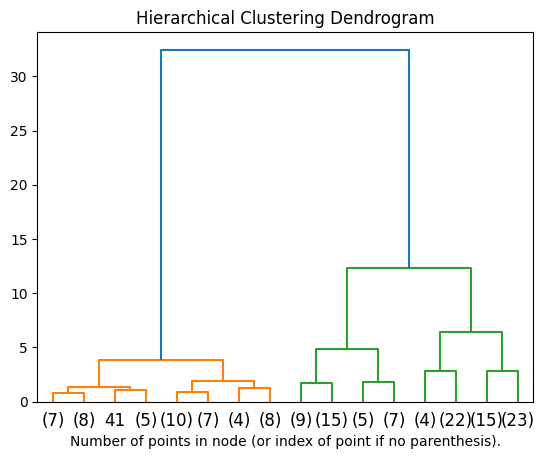

In [48]:
# courtosy sklearn.org
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris


X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel('Number of points in node (or index of point if no parenthesis).')
plt.show()

In [49]:
newmodel = AgglomerativeClustering(n_clusters=3)
iris_df['heirarchical_labels'] = newmodel.fit_predict(X)


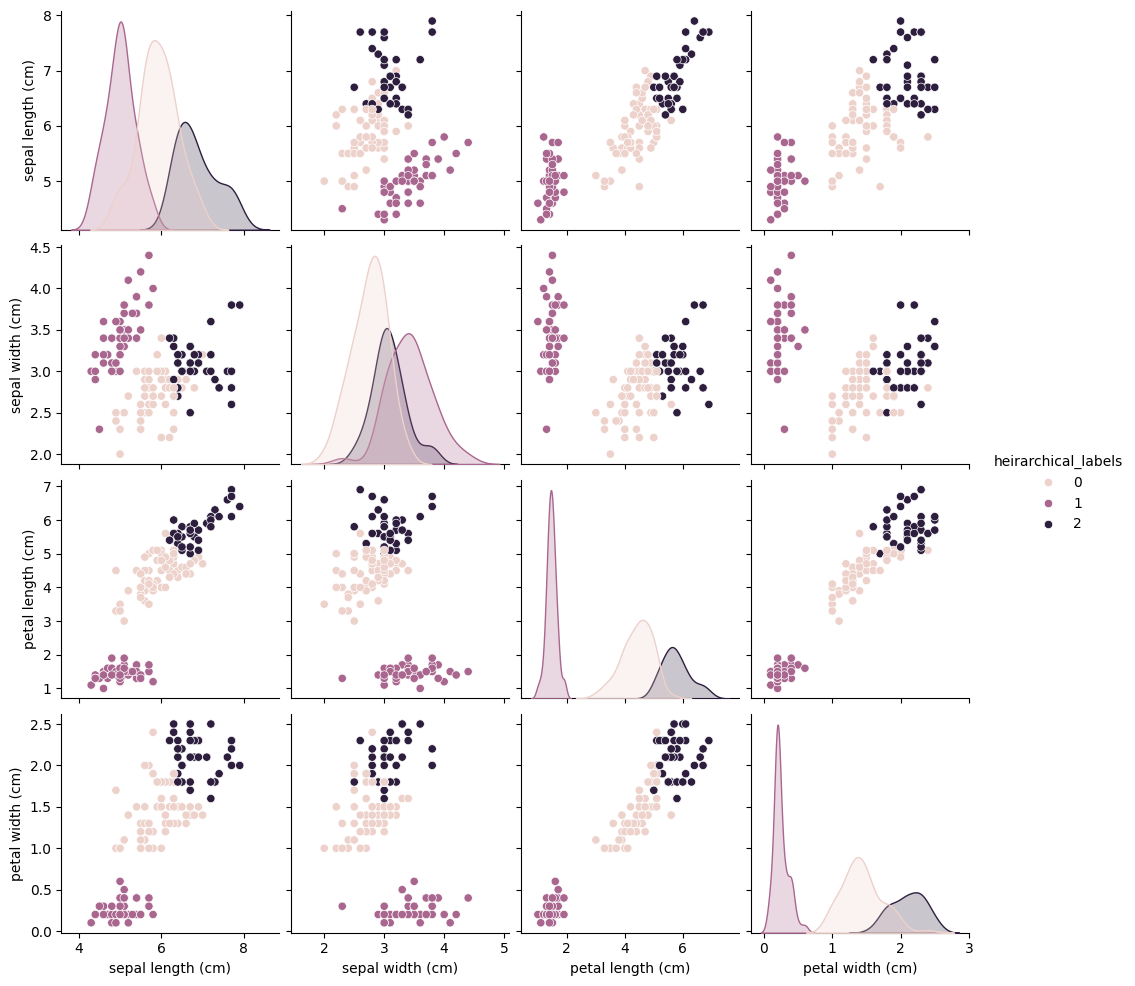

In [50]:
cols = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']
sns.pairplot(iris_df, vars=cols, hue='heirarchical_labels')

In [51]:
confusion_matrix(iris_df.heirarchical_labels, iris_labeled_df['species_index'])

array([[ 0, 49, 15],
       [50,  0,  0],
       [ 0,  1, 35]])

In [52]:
# again, we shuffle since our algorithm is "untrained"
# performance is similar
h_map_cluster_dict = dict(zip((1, 0, 2), (0, 1, 2) ))
confusion_matrix(iris_df.heirarchical_labels.map(h_map_cluster_dict), iris_labeled_df['species_index'])

array([[50,  0,  0],
       [ 0, 49, 15],
       [ 0,  1, 35]])

In [53]:
accuracy_score(iris_df.heirarchical_labels.map(h_map_cluster_dict), iris_labeled_df['species_index'])

0.8933333333333333

## DBSCAN 

In [54]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN().fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 17


DBSCAN  doesn't do a great job, since the metrics of two of the species are spatially similar.  So, it finds 2 clusters rather than 3

# Market Analysis with APRIORI:  Coffee Shop Orders

In [55]:
# %pip install mlxtend
# %pip install networkx
import numpy as np 
import pandas as pd 
from mlxtend.frequent_patterns import apriori, association_rules 

In [56]:
df = pd.read_csv('data/Coffe Shop Sales.xlsx - MBA_Master.csv')

# Show the first 10 data points.
df.head(10)

,transaction_number,amount,item
0,6,1,Latte Hot
1,6,1,Americano Hot
2,6,1,V60
3,6,1,Brownies
4,7,1,V60
5,7,1,Pain Au Chocolat
6,8,1,V60
7,9,1,Pistachio Croissant
8,9,1,V60
9,9,1,Carrot cake


In [57]:
df_pivot = df.pivot_table(index='transaction_number', columns='item', values='amount', aggfunc='sum').fillna(0)

# Show the size of the pivoted table.
print('Table size: %d rows \u00d7 %d columns' % df_pivot.shape)

Table size: 3131 rows × 45 columns


In [58]:
# Show what the top transactions with the highest amounts look like transposed.
def is_within_threshold(value):
    return 4 < value

df_pivot[df_pivot.select_dtypes(np.number)
                 .apply(is_within_threshold, axis=1)
                 .any(axis=1)] \
        .T \
        .style \
        .background_gradient(axis=None) \
        .format('{:,.0f}')

transaction_number,1096,1160,1337,2296,2430,2620,2650,3157,4708,5580,5666
item,,,,,,,,,,,
Almond Croisant,0,0,1,0,0,0,0,0,5,0,0
Americano Hot,2,0,1,0,0,1,0,0,1,0,1
Americano Iced,0,0,0,0,0,0,1,0,0,0,0
Apple Turnover,0,0,0,0,0,0,0,0,0,0,0
Blueberry Muffins,0,0,0,0,0,0,0,0,0,0,0
Brownies,0,0,0,0,0,0,0,0,1,0,0
Cake Of The Day,0,0,0,0,0,1,1,0,0,0,0
Cappucino Hot,2,0,0,0,0,5,0,0,0,0,1
Cappucino Iced,0,0,0,0,5,0,0,0,0,0,0


In [59]:
def encode(value):        # You get a False if the value is not greater than 0, which becomes a 0;
    return int(0 < value) # you get a True if the value is greater than 0, which becomes a 1.

df_pivot = df_pivot.map(encode)

# Show what the first 10 look like transposed.
def determine_style(condition):                                      # The condition is an array of True or False (from previous encoding step)
    return np.where(condition, 'background: navy; color: white', '') # If True, the background color is defined (navy/white); if False, it is not defined.

df_pivot.head(10) \
        .T \
        .style \
        .apply(determine_style, axis=None)

AttributeError: 'DataFrame' object has no attribute 'map'

In [ ]:
# our minimum support
support = 0.01 
frequent_items = apriori(df_pivot, min_support=support, use_colnames=True)
frequent_items.sort_values('support', ascending=False)

"Lift" is the ratio of the target reponse given the antecedent relative to no condition. In conditional probability speak this is:
$$
L = \frac{P_{A|B}}{P_B}
$$
High lift suggests that the products tend to purchased together

In [ ]:
metric = 'lift'
min_treshold = 1

rules = association_rules(frequent_items, metric=metric, min_threshold=min_treshold)[['antecedents','consequents','support','confidence','lift']]
rules.reset_index(drop=True).sort_values('confidence', ascending=False, inplace = True)

# Show the metrics.
rules.sort_values(['antecedents', 'consequents']) \
     .set_index(['antecedents', 'consequents']) \
     .style \
     .set_table_styles([{'selector': 'th.row_heading', 'props': [('vertical-align', 'text-top')]}]) \
     .background_gradient(axis=0) \
     .format_index(', '.join)

In [ ]:
# First we build a network from the association rule data
import networkx as nx

from_nodes = rules.antecedents.apply(', '.join)
to_nodes = rules.consequents.apply(', '.join)
cxns = zip(from_nodes, to_nodes)

G = nx.MultiDiGraph()
G.add_edges_from(cxns)


In [ ]:
plt.figure(1, figsize=(8, 8))
nx.draw_networkx(G, arrows=True, node_size=1000, font_size=10, node_color='tab:green', font_color='blue', connectionstyle='arc3, rad=0.1')


Here, we see that the arrows flow both ways.  This shouldn't be suprising since the data contains purchases that happen at the same time.  

In [69]:
rules_even = rules.iloc[::2, :].copy() # Keep only even rows.
rules_even.antecedents = rules_even.antecedents.apply(', '.join) # Get rid of frozensets.
rules_even.consequents = rules_even.consequents.apply(', '.join) # Get rid of frozensets.
rules_even['cxns'] = rules_even['antecedents'] + ' \u27f7 ' + rules_even['consequents']
rules_even= rules_even.sort_values('lift', ascending=False)

In [ ]:
sns.barplot(rules_even, y='cxns', x='lift').set_title('Coffee Shop Product Lift')

Apparently, the sweet tooth wins out!  

Let’s make some predictions!

If a person is placing an order for certain items, what are the best suggestions for additional items based on the association rules we’ve mined?

In [60]:
from IPython.display import display, display_markdown

def suggest_product_for(antecedents, limit=5):                  # Given a list of antecedents, predict some consequents up to the limit.
    antecedents = frozenset(antecedents)
    condition = rules.antecedents.map(antecedents.issuperset)   # The given antecedents must be a superset of the rules' antecedents.
    candidates = rules[condition].explode('consequents')        # Explode to expand the tuple/set/list to individual rows.
    suggestions = candidates[~candidates.consequents.isin(antecedents)] \
                            .sort_values('lift', ascending=False) \
                            .drop_duplicates('consequents')     # Sort and then remove suggestions which are already among the antecedents and deduplicate.
    return suggestions.head(limit)

for antecedents in [{'Plain Croisant'},
                    {'Decaf Coffee'},
                    {'Plain Croisant', 'Decaf Coffee'}]:
    display_markdown(f'Suggestions for *{", ".join(antecedents)}*', raw=True)
    display(suggest_product_for(antecedents))

Suggestions for *Plain Croisant*

NameError: name 'rules' is not defined